<a href="https://colab.research.google.com/github/garrettfarley9/AI-Final-Project/blob/main/AI_final_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
##Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint




#Mushroom Data Neural Network for Binary Classification using Keras

##Phase 1 - Data Analysis

First I want to dive in and check for any relationships I can see with some plots and datatype readouts. I want to see the shape of the dataset and breakdown of each feature checking for NA's or features I can drop right off the bat.

In [3]:
##Reading in data and calculating proportions of classes

# mdf = pd.read_csv('https://www.kaggle.com/datasets/ulrikthygepedersen/mushroom-attributes/download?datasetVersionNumber=1')
mdf = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/mushroom.csv')
counts = mdf.groupby(['class']).size()

mdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8124 entries, 0 to 8123
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   cap-shape                 8124 non-null   object
 1   cap-surface               8124 non-null   object
 2   cap-color                 8124 non-null   object
 3   bruises%3F                8124 non-null   object
 4   odor                      8124 non-null   object
 5   gill-attachment           8124 non-null   object
 6   gill-spacing              8124 non-null   object
 7   gill-size                 8124 non-null   object
 8   gill-color                8124 non-null   object
 9   stalk-shape               8124 non-null   object
 10  stalk-root                8124 non-null   object
 11  stalk-surface-above-ring  8124 non-null   object
 12  stalk-surface-below-ring  8124 non-null   object
 13  stalk-color-above-ring    8124 non-null   object
 14  stalk-color-below-ring  

In [34]:
##Describe the dataset
mdf.describe().T


,count,unique,top,freq
cap-shape,8124,6,b'x',3656
cap-surface,8124,4,b'y',3244
cap-color,8124,10,b'n',2284
bruises%3F,8124,2,b'f',4748
odor,8124,9,b'n',3528
gill-attachment,8124,2,b'f',7914
gill-spacing,8124,2,b'c',6812
gill-size,8124,2,b'b',5612
gill-color,8124,12,b'b',1728
stalk-shape,8124,2,b't',4608


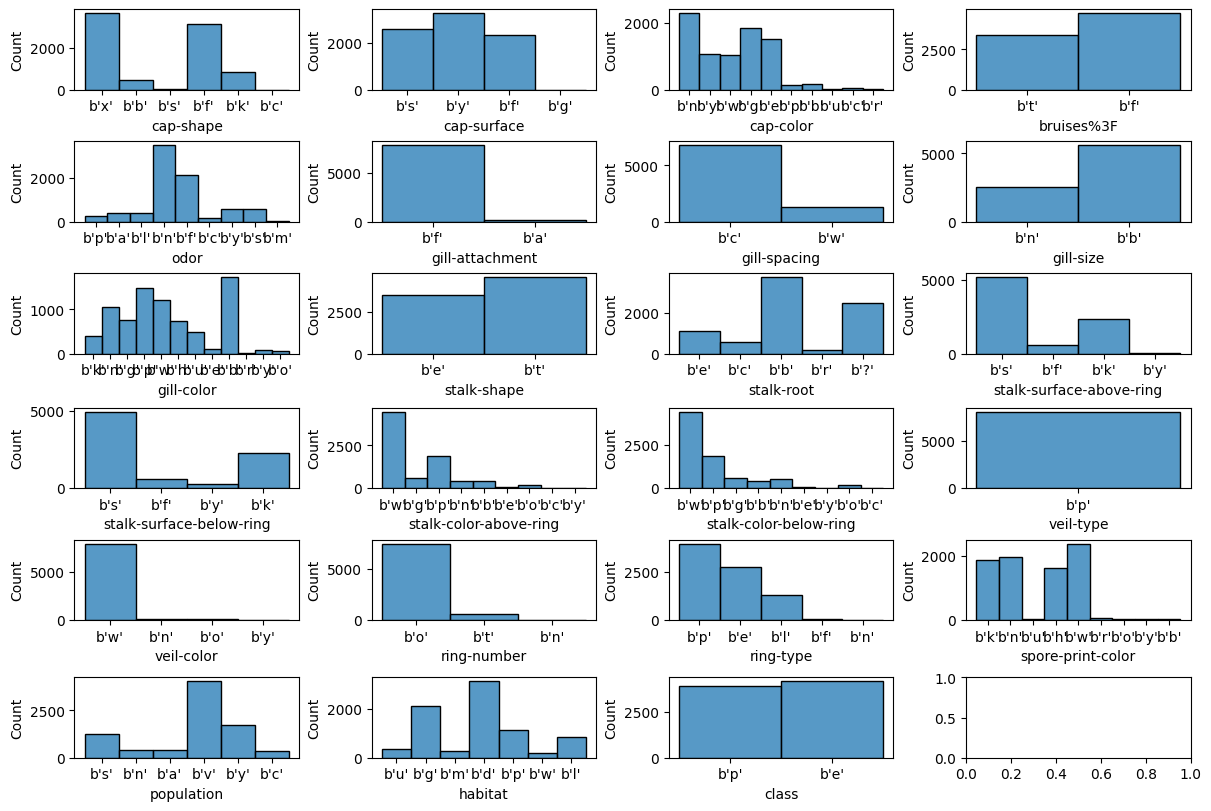

In [35]:
#Plotting each feature count on a histogram
fig, ax = plt.subplots(nrows = 6, ncols = 4, figsize = (12,8), layout = 'constrained')
ax = ax.flatten()
for i, col in enumerate(mdf.columns):
    sns.histplot(mdf[col], ax=ax[i])
# plt.tight_layout()


I'm noticing that 'veil-type' is the same for every observation so we can safely drop that column. I'm also seeing that the edible and poisonous classes are both pretty evenly distributed so I won't have to do any data transformations. Since these features are categorical and on the same scale as the class variable, I'm not going to normalize any of the features. I will run a label encoder to give a numerical value to each category in each feature. This normally insinuates ordinality in categorical data, which is not the case here, but this is prefered to one hot encoding where multicollinearity could occur and we would get a lot of dummy variables with the number of categorical features we have.

In [4]:
## Drop 'veil-type'
mdf = mdf.drop(labels = 'veil-type', axis = 1)

##Label encoding
cols = mdf.columns
for c in cols:
  uni = mdf[c].unique()
  map = {}
  for x in range(len(uni)):
    map[uni[x]] = x
  mdf[c].replace(map, inplace= True)



In [5]:
mdf.head()

,cap-shape,cap-surface,cap-color,bruises%3F,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-color,ring-number,ring-type,spore-print-color,population,habitat,class
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,1,0,1,0,0,1,0,0,...,0,0,0,0,0,0,1,1,1,1
2,1,0,2,0,2,0,0,1,1,0,...,0,0,0,0,0,0,1,1,2,1
3,0,1,2,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,3,1,3,0,1,1,0,1,...,0,0,0,0,0,1,1,2,1,1


The last thing I want to do is check for any obvious correlation between any of the features and the class variable. As you can see, there aren't too many strong relationships with the class variable. Ring type, odor, stalk surface above ring, stalk surface below ring, and spore print color all had ~-50 linear relationship. Gill size had a ~50 positive relationship

<Axes: >

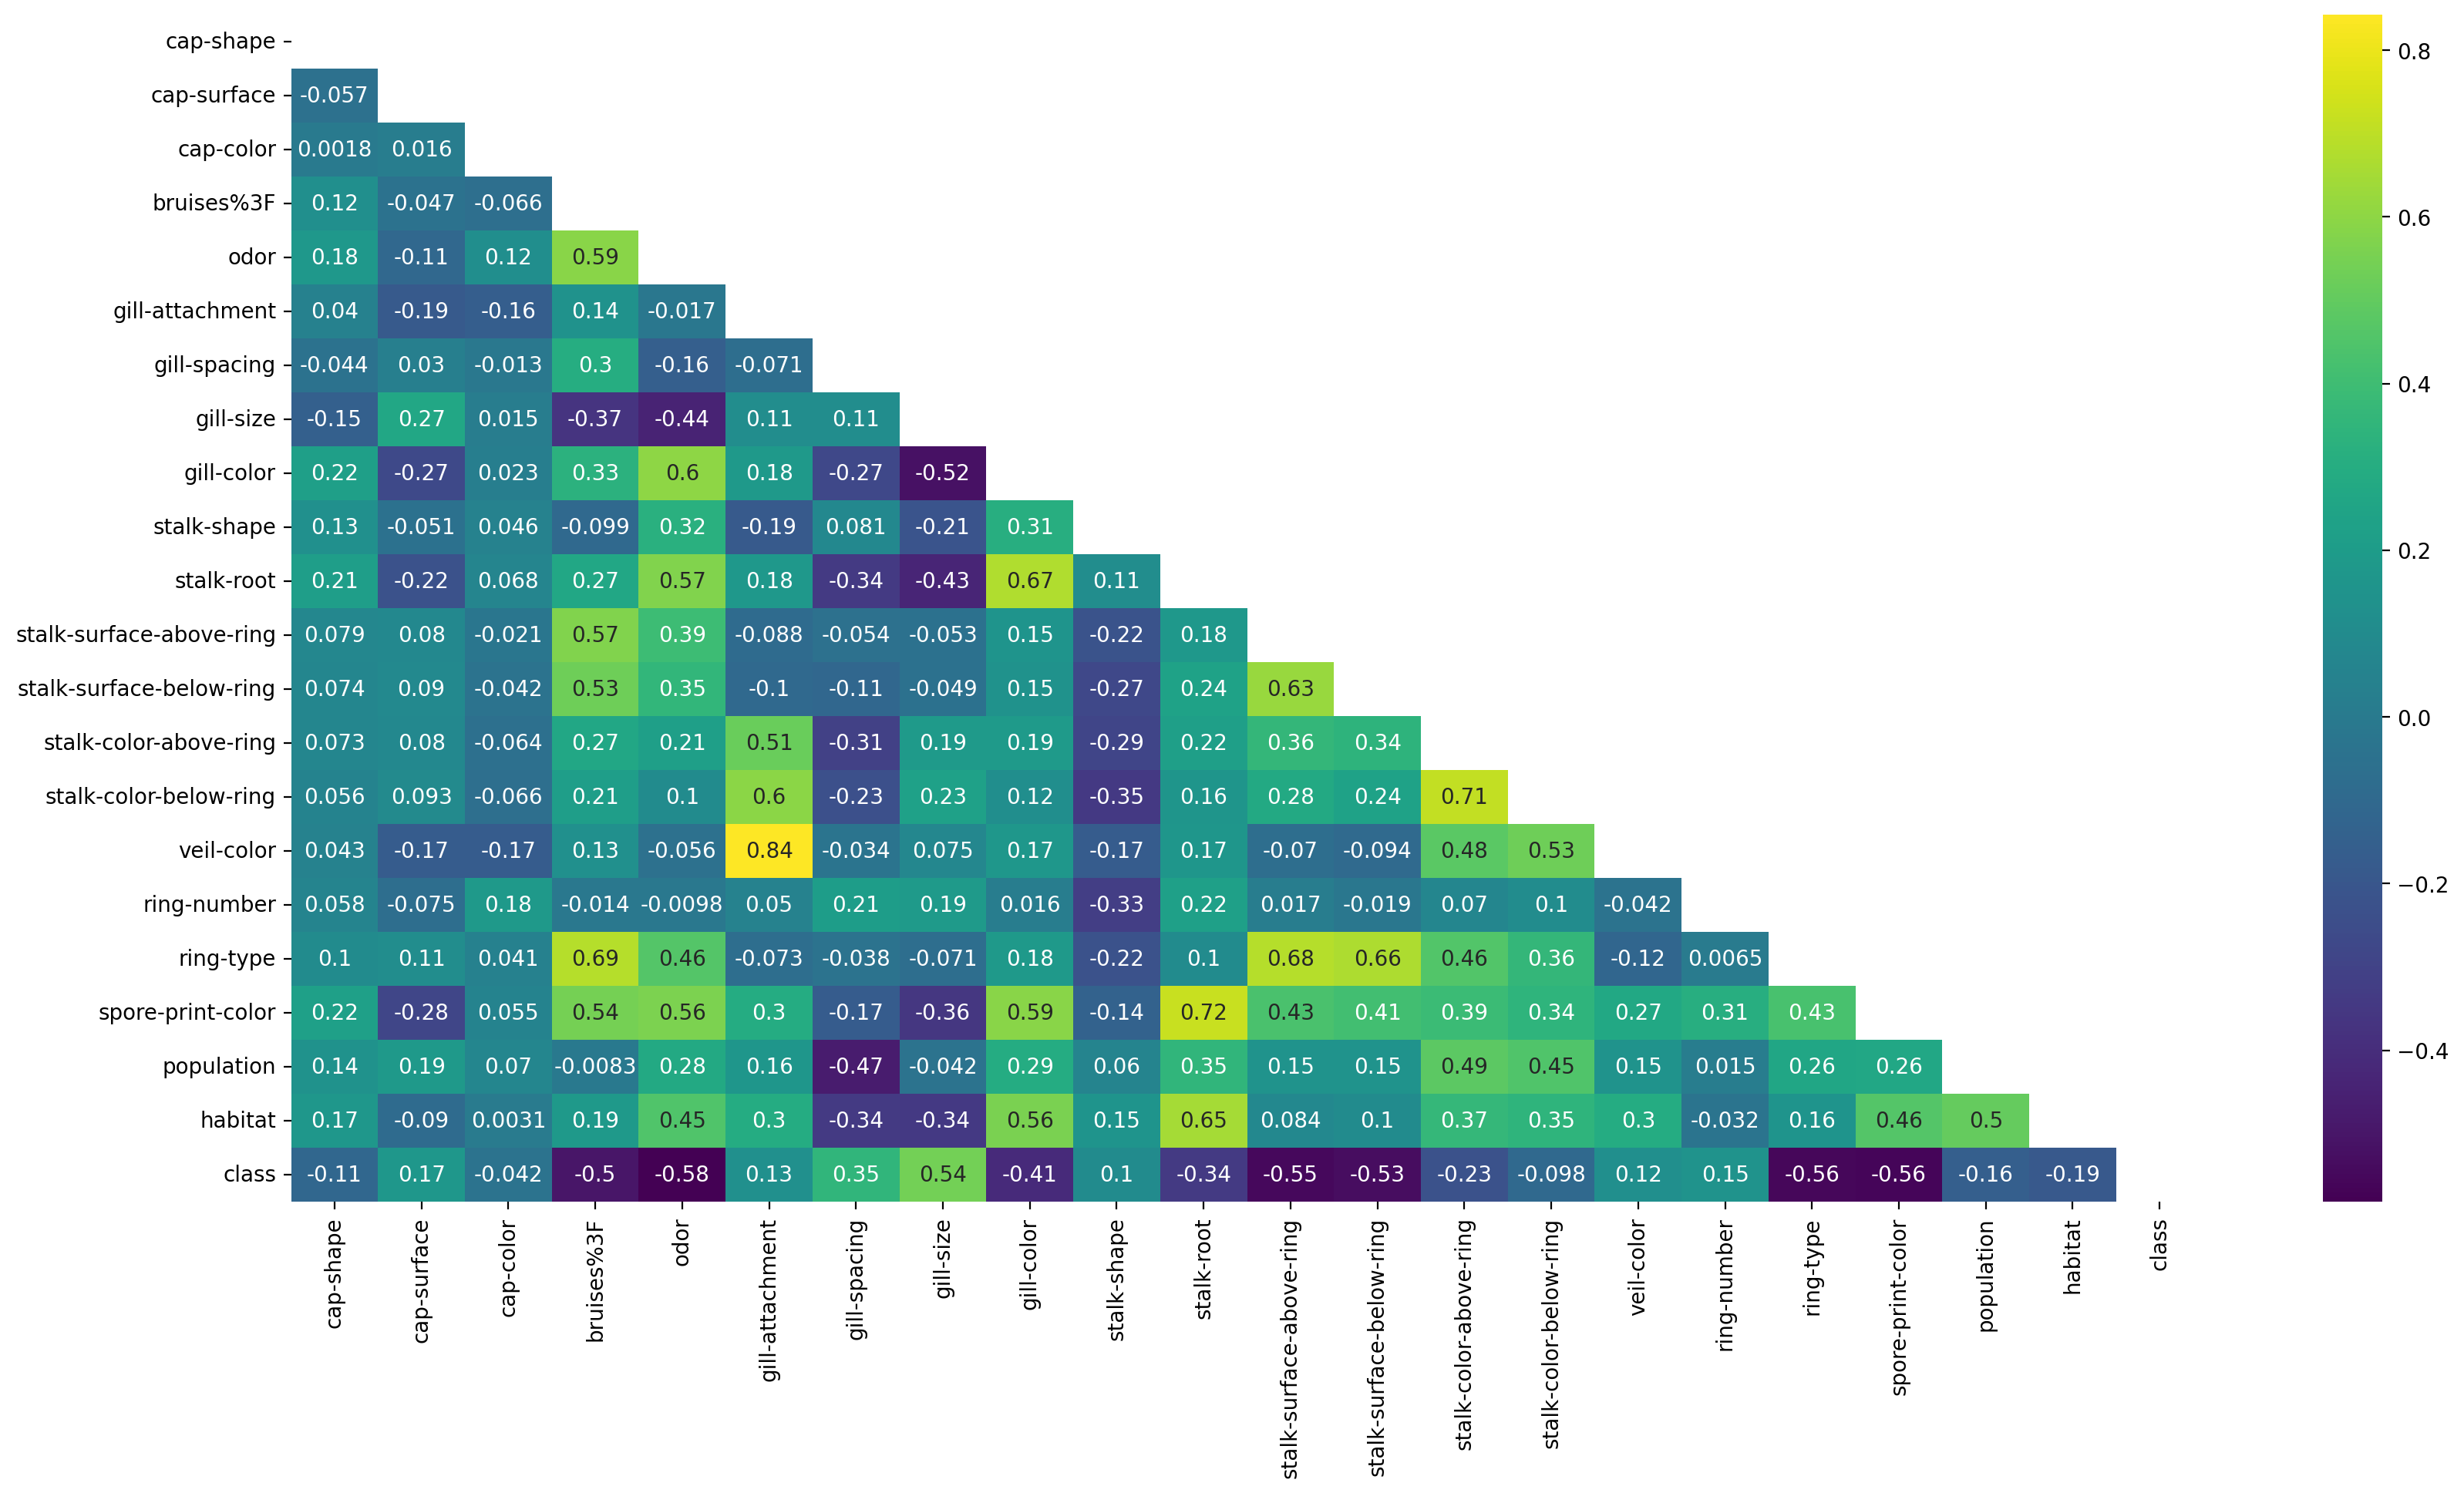

In [6]:
mask = np.triu(np.ones_like(mdf.corr(numeric_only = True), dtype=bool))
plt.figure(figsize=(20,10),dpi=200)
sns.heatmap(data = mdf.corr(numeric_only = True), mask = mask, annot=True,cmap='viridis')

##Phase 2 - Model Selection and Validation

In this phase I will train a few models to see how large the neural net needs to be to give acceptable results. 

###Splitting Data

In [7]:
##Shuffle the data to mitigate overfitting
np.random.shuffle(mdf.values)

##Split into training and testing

index_20percent = int(0.2 * len(mdf.index))
test = mdf[:index_20percent]
train = mdf[index_20percent:]

XVALID = test.drop(columns = 'class')
YVALID = pd.DataFrame(test['class'])
XTRAIN = train.drop(columns = 'class', axis = 1)
YTRAIN = pd.DataFrame(train['class'])
shapes = [XTRAIN, YTRAIN, XVALID, YVALID]
for i in shapes:
  print(i.shape)

(6500, 21)
(6500, 1)
(1624, 21)
(1624, 1)


###Dummy Classifier
Here I will calculate the dummy classifier. This accounts for the proportion of the binary classifier frequency. Since the fequency of each label is about the same, the dummy classifier works similarly to a coin toss.

In [ ]:
##Dummy classifier
counts['p'] = [counts[0] / (counts[0]+counts[1]) , counts[1] / (counts[0]+counts[1])]
print(counts)
baseline = counts['p'][0]**2 + counts['p'][1]**2
print(baseline)

class
b'e'                                        4208
b'p'                                        3916
p       [0.517971442639094, 0.48202855736090594]
dtype: object
0.5006459455010605


###Neural Net Models
This function will loop through various models taken in as parameters and print out the accuracies of each model.

In [9]:
##Log callbacks for model checkpoints
callback_a = ModelCheckpoint(filepath = 'best_model', monitor = 'val_loss', save_best_only = True, save_weights_only = True)
callback_b = EarlyStopping(monitor = 'val_loss', mode = 'min', patience = 20, verbose = 1)


In [43]:
##Iterate through different complexities of neural network models
def model_mash(first = [], hiddens = [[]]):
  models = []
  first = first
  hiddens = hiddens
  callback_b = EarlyStopping(monitor = 'val_loss', mode = 'min', patience = 20, verbose = 0)
  for k in range(len(first)):
    inst = Sequential()
    inst.add(Dense(first[k], input_dim = 21, activation = 'relu'))
    for l in range(len(hiddens[k])):
      inst.add(Dense(hiddens[k][l], activation = 'relu'))
    inst.add(Dense(1, activation = 'sigmoid'))
    # print(inst.summary())
    inst.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
    history = inst.fit(XTRAIN, YTRAIN, validation_data = (XVALID, YVALID), epochs = 100, batch_size = 10, callbacks = [callback_a,callback_b], verbose = 0)
    scores_train = inst.evaluate(XTRAIN, YTRAIN)
    scores_test = inst.evaluate(XVALID, YVALID)
    models.append([inst, inst.metrics_names[1], scores_train[1]*100, scores_test[1]*100])
##Show the datatable for the accuracy of each model against the others
  print('-Model- :', '-Training Acc- :', '-Test Acc-')
  for x in range(len(models)):
    print(first[x], hiddens[x], '1', ':' , models[x][2], ':', models[x][3])



In [44]:
##Call the function
model_mash(first = [32,16,8,4,2], hiddens = [[16,8],[8],[],[],[]])

51/51 [==============================] - 0s 1ms/step - loss: 0.0135 - accuracy: 0.9994
-Model- : -Training Acc- : -Test Acc-
32 [16, 8] 1 : 100.0 : 100.0
16 [8] 1 : 100.0 : 100.0
8 [] 1 : 100.0 : 100.0
4 [] 1 : 100.0 : 100.0
2 [] 1 : 99.72307682037354 : 99.93842244148254


##Phase 3 - Validation

###Confusion Matrix

##Phase 4 - Feature Importance
###This section tries to see which features matter more during the training process. I will loop through each column in the training dataset and see what the test scores will be. 

###Importance of each feature

In [49]:

fYTRAIN = YTRAIN
fYTEST = YVALID
bars_name = []
bars_val = []

for f in range(len(cols)-1):
  fXTRAIN = XTRAIN[cols[f]]
  fXTEST = XVALID[cols[f]]
  feat = Sequential()
  feat.add(Dense(2, input_dim = 1, activation = 'relu'))
  feat.add(Dense(1, activation = 'sigmoid'))
  feat.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
  history_feat = feat.fit(fXTRAIN, fYTRAIN, validation_data = (fXTEST,fYTEST), epochs = 10, batch_size = 10, callbacks = [callback_a,callback_b], verbose = 0)
  fscore = feat.evaluate(fXTEST, fYTEST)
  bars_name.append(cols[f])
  bars_val.append(fscore[1]*100)




51/51 [==============================] - 0s 975us/step - loss: 0.6637 - accuracy: 0.6441


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20]),
 [Text(0, 0, 'odor'),
  Text(1, 0, 'spore-print-color'),
  Text(2, 0, 'stalk-surface-below-ring'),
  Text(3, 0, 'bruises%3F'),
  Text(4, 0, 'population'),
  Text(5, 0, 'gill-color'),
  Text(6, 0, 'stalk-color-above-ring'),
  Text(7, 0, 'stalk-root'),
  Text(8, 0, 'gill-spacing'),
  Text(9, 0, 'stalk-shape'),
  Text(10, 0, 'cap-shape'),
  Text(11, 0, 'veil-color'),
  Text(12, 0, 'stalk-surface-above-ring'),
  Text(13, 0, 'cap-surface'),
  Text(14, 0, 'gill-size'),
  Text(15, 0, 'stalk-color-below-ring'),
  Text(16, 0, 'ring-number'),
  Text(17, 0, 'ring-type'),
  Text(18, 0, 'gill-attachment'),
  Text(19, 0, 'cap-color'),
  Text(20, 0, 'habitat')])

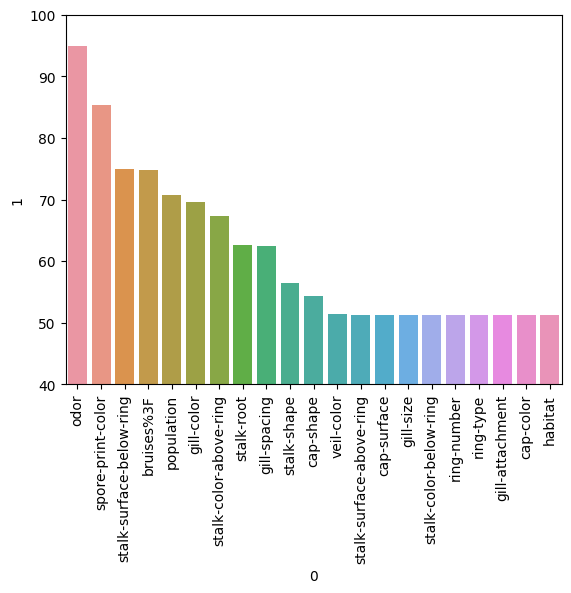

In [45]:
daf = pd.concat([pd.Series(bars_name), pd.Series(bars_val)], axis=1)
daf.sort_values(by = 1, inplace = True, ascending = False)
ax = sns.barplot(x = daf[0], y = daf[1])
ax.set(ylim=(40, 100))
plt.xticks(rotation='vertical')

In [48]:
# j = daf[0][daf[1] == min(daf[1])]
# print(j[0])
# print(daf.columns[1])
# print(daf[0])
derf = daf.copy()
derf.drop(derf.tail(1).index,inplace=True)
# derf = daf.drop(daf.iloc[:-1,:])
# derf = derf.drop(derf.iloc[:,:-1])
# b = fXTRAIN.drop(daf[0][daf[1] == min(daf[1])])
print(derf)
daf[0][daf[1] == min(daf[1])]

                           0          1
4                       odor  95.012313
18         spore-print-color  85.344827
12  stalk-surface-below-ring  74.938422
3                 bruises%3F  74.815273
19                population  70.689654
8                 gill-color  69.642860
13    stalk-color-above-ring  67.302954
10                stalk-root  62.561578
6               gill-spacing  62.438422
9                stalk-shape  56.403941
0                  cap-shape  54.433495
15                veil-color  51.416254
11  stalk-surface-above-ring  51.354682
1                cap-surface  51.354682
7                  gill-size  51.354682
14    stalk-color-below-ring  51.354682
16               ring-number  51.354682
17                 ring-type  51.354682
5            gill-attachment  51.354682
2                  cap-color  51.354682


###The effect of iteratively excluding least important features in the network

51/51 [==============================] - 0s 2ms/step - loss: 7.0893e-04 - accuracy: 1.0000
Epoch 66: early stopping
51/51 [==============================] - 0s 2ms/step - loss: 0.0173 - accuracy: 0.9938
Epoch 73: early stopping
51/51 [==============================] - 0s 1ms/step - loss: 0.0371 - accuracy: 0.9914
Epoch 82: early stopping
51/51 [==============================] - 0s 2ms/step - loss: 0.0697 - accuracy: 0.9594
Epoch 86: early stopping
51/51 [==============================] - 0s 2ms/step - loss: 0.3714 - accuracy: 0.8750
Epoch 82: early stopping
51/51 [==============================] - 0s 1ms/step - loss: 0.5834 - accuracy: 0.6238
Epoch 95: early stopping
51/51 [==============================] - 0s 2ms/step - loss: 0.1512 - accuracy: 0.9563
Epoch 92: early stopping
51/51 [==============================] - 0s 2ms/step - loss: 0.1545 - accuracy: 0.9563


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21]),
 [Text(0, 0, '0cap-shape'),
  Text(1, 0, '1cap-surface'),
  Text(2, 0, '2cap-color'),
  Text(3, 0, '3bruises%3F'),
  Text(4, 0, '4odor'),
  Text(5, 0, '5gill-attachment'),
  Text(6, 0, '6gill-spacing'),
  Text(7, 0, '7gill-size'),
  Text(8, 0, '8gill-color'),
  Text(9, 0, '9stalk-shape'),
  Text(10, 0, '10stalk-root'),
  Text(11, 0, '11stalk-surface-above-ring'),
  Text(12, 0, '12stalk-surface-below-ring'),
  Text(13, 0, '13stalk-color-above-ring'),
  Text(14, 0, '14stalk-color-below-ring'),
  Text(15, 0, '15veil-type'),
  Text(16, 0, '16veil-color'),
  Text(17, 0, '17ring-number'),
  Text(18, 0, '18ring-type'),
  Text(19, 0, '19spore-print-color'),
  Text(20, 0, '20population'),
  Text(21, 0, '21habitat')])

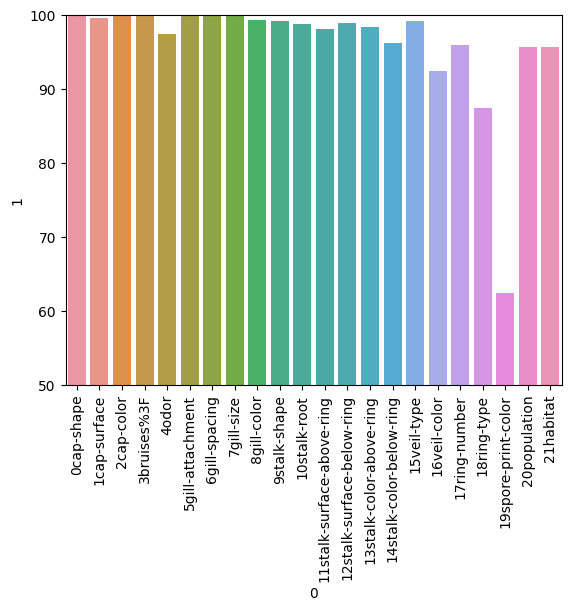

In [ ]:
fXTRAIN = XTRAIN.copy()
fXTEST = XVALID.copy()
colx = daf[0].reset_index()
# colx = colx.reset_index()
bars2_name = []
bars2_val = []
counter = 21
for f in range(len(cols)-1):
  feat = Sequential()
  feat.add(Dense(2, input_dim = counter, activation = 'relu'))
  feat.add(Dense(1, activation = 'sigmoid'))
  feat.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
  history_feat = feat.fit(fXTRAIN, fYTRAIN, validation_data = (fXTEST,fYTEST), epochs = 100, batch_size = 10, callbacks = [callback_a,callback_b], verbose = 0)
  fscore = feat.evaluate(fXTEST, fYTEST)
  bars2_name.append(str(f) + cols[f])
  bars2_val.append(fscore[1]*100)
  fXTRAIN = fXTRAIN.drop(daf[0][daf[1] == min(daf[1])])
  fXTEST = fXTEST.drop(str(colx[0][f]), axis = 1)
  counter -= 1
edf = pd.concat([pd.Series(bars2_name), pd.Series(bars2_val)], axis=1)
ax = sns.barplot(x = edf[0], y = edf[1])
ax.set(ylim=(50, 100))
plt.xticks(rotation='vertical')
